In [ ]:
!pip install pandas openpyxl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, f1_score
import graphviz
from IPython.display import display
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder


In [ ]:
# 1. Load the Excel file
excel_file = "/content/heart_disease.xlsx"

# 2. Read a specific sheet (optional)
df = pd.read_excel(excel_file, sheet_name="Heart_disease")

# 3. Save as CSV
df.to_csv("heart_disease.csv", index=False)

In [ ]:

# FIX: Strip whitespace from column names to prevent KeyError
df.columns = df.columns.str.strip()

In [ ]:
# Define feature lists
numerical_cols = ['age', 'trestbps', 'chol', 'thalch', 'oldpeak']
categorical_cols = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']


In [ ]:
# 1a. Convert target column (using index -1 for robustness)

# 1. Get the actual name of the last column (which is the corrupted 'num' column)
TARGET_COL_NAME = df.columns[-1]

# 2. Create the new binary 'target' column (0 or 1)
df['target'] = df[TARGET_COL_NAME].apply(lambda x: 1 if x > 0 else 0)

# 3. Drop the original column using its actual name
df.drop(TARGET_COL_NAME, axis=1, inplace=True)

In [ ]:
# 1b. Handle missing values: Replace '?' with NaN and convert types
df.replace('?', np.nan, inplace=True)
df[numerical_cols] = df[numerical_cols].apply(pd.to_numeric)


In [ ]:
# 1c. Impute missing values with mode (categorical) and mean (numerical)
df[categorical_cols] = df[categorical_cols].fillna(df[categorical_cols].mode().iloc[0])
df[numerical_cols] = df[numerical_cols].fillna(df[numerical_cols].mean())


In [ ]:
# 1d. One-Hot Encoding for categorical features
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)


In [ ]:
# 1e. Separate Features (X) and Target (y)
X = df_encoded.drop('target', axis=1)
y = df_encoded['target']


In [ ]:
# 1f. Scale Numerical Features (Task 3)
scaler = StandardScaler()
# Note: Scaling the whole X to maintain columns integrity with Scaler
X_cols = X.columns.tolist()
scaled_X = scaler.fit_transform(X)
X = pd.DataFrame(scaled_X, columns=X_cols)


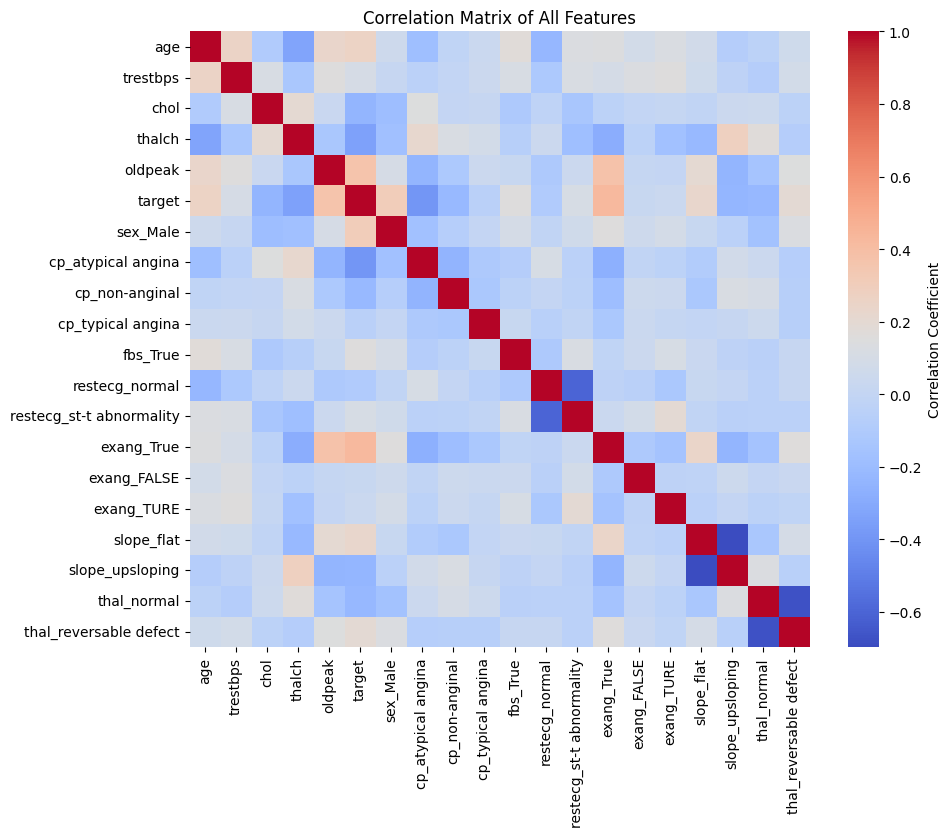

In [ ]:
#  2. Exploratory Data Analysis (EDA) Visualizations (Task 2)
# A. Correlation Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df_encoded.corr(), cmap='coolwarm', fmt=".1f",
            cbar_kws={'label': 'Correlation Coefficient'})
plt.title('Correlation Matrix of All Features')
plt.show()

/tmp/ipython-input-685369575.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='target', y='oldpeak', data=df, ax=axes[1, 0], palette='pastel')
/tmp/ipython-input-685369575.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='target', y='age', data=df, ax=axes[1, 1], palette='pastel')


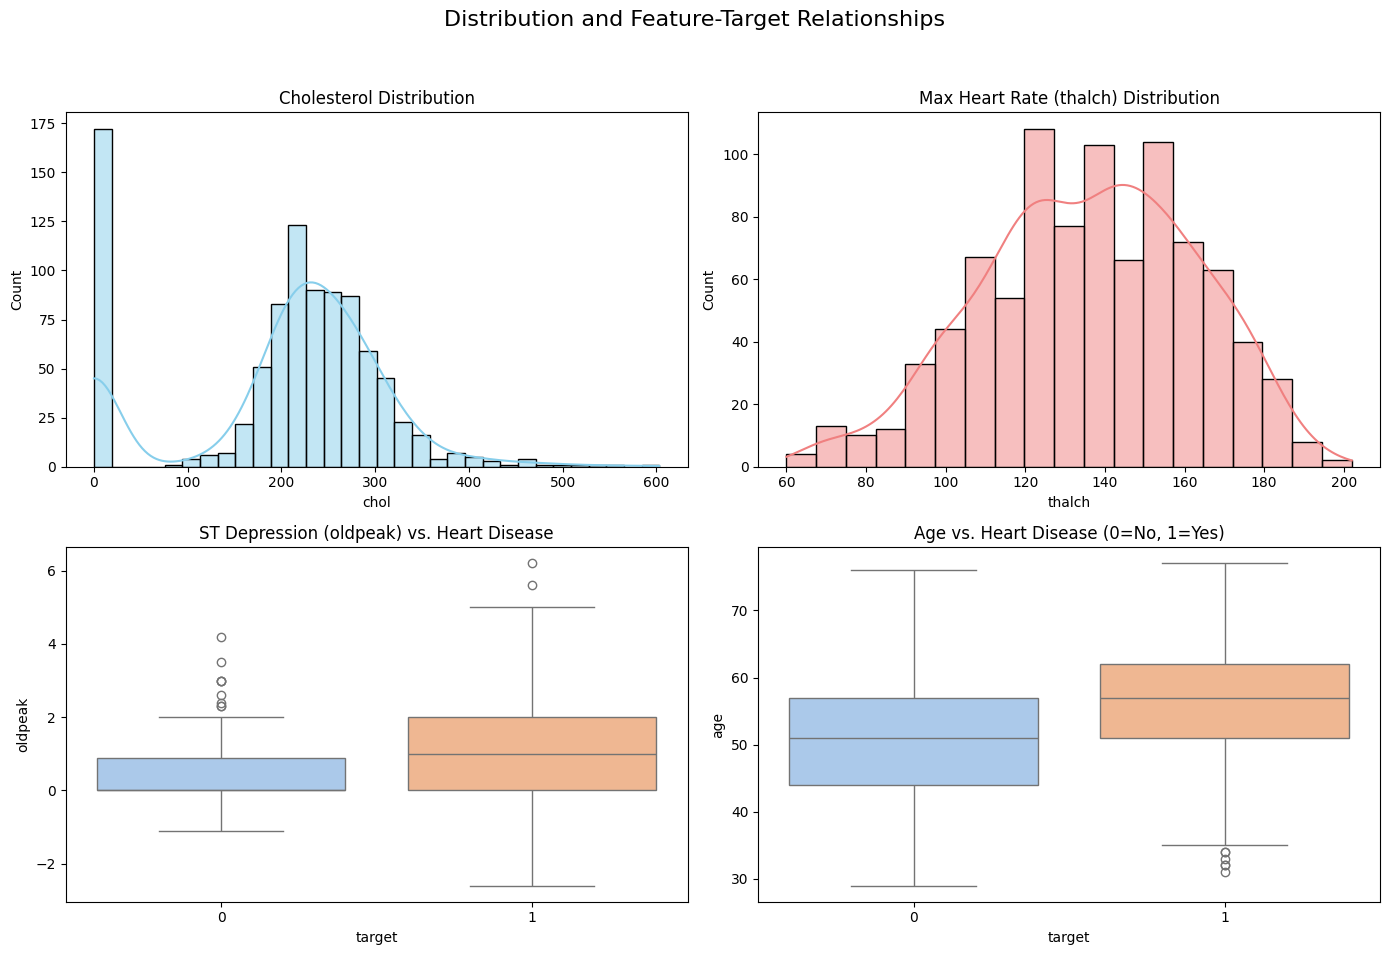

In [ ]:
# B. Distribution and Relationship Plots (Histograms & Box Plots)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Distribution and Feature-Target Relationships', fontsize=16)

# Histogram for Cholesterol
sns.histplot(df['chol'], kde=True, ax=axes[0, 0], color='skyblue')
axes[0, 0].set_title('Cholesterol Distribution')

# Box Plot for Oldpeak vs. Target
sns.boxplot(x='target', y='oldpeak', data=df, ax=axes[1, 0], palette='pastel')
axes[1, 0].set_title('ST Depression (oldpeak) vs. Heart Disease')

# Histogram for Max Heart Rate (thalch)
sns.histplot(df['thalch'], kde=True, ax=axes[0, 1], color='lightcoral')
axes[0, 1].set_title('Max Heart Rate (thalch) Distribution')

# Box Plot for Age vs. Target
sns.boxplot(x='target', y='age', data=df, ax=axes[1, 1], palette='pastel')
axes[1, 1].set_title('Age vs. Heart Disease (0=No, 1=Yes)')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [ ]:
# 3. Model Training and Hyperparameter Tuning (Tasks 4 & 5)
# Split the dataset (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [ ]:
# Define the parameter grid for tuning
param_grid = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy']
}


In [ ]:
# Initialize and fit GridSearchCV
dt_clf = DecisionTreeClassifier(random_state=42)
grid_search = GridSearchCV(estimator=dt_clf, param_grid=param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 5, 7, 10, None],
                         'min_samples_split': [2, 5, 10]},
             scoring='f1')

In [ ]:
# Get the best model
best_dt = grid_search.best_estimator_


In [ ]:
#  4. Model Evaluation (Task 6 - Metrics)
y_pred = best_dt.predict(X_test)
y_proba = best_dt.predict_proba(X_test)[:, 1]
report = classification_report(y_test, y_pred, output_dict=True)

print("\n--- 4. Final Model Evaluation on Test Set ---")
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Accuracy: {report['accuracy']:.4f}")
print(f"F1 Score (Disease Class 1): {report['1']['f1-score']:.4f}")
print(f"ROC AUC Score: {roc_auc_score(y_test, y_proba):.4f}")



--- 4. Final Model Evaluation on Test Set ---
Best Parameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 10}
Accuracy: 0.7527
F1 Score (Disease Class 1): 0.7847
ROC AUC Score: 0.8117


In [ ]:
#  5. Decision Tree Structure Visualization (Task 6 - Visualization)
print("\n--- 5. Decision Tree Structure Visualization ---")

dot_data = export_graphviz(
    best_dt,
    feature_names=X.columns,
    class_names=['No Disease', 'Disease'],
    filled=True,
    rounded=True,
    special_characters=True,
    impurity=False,
    proportion=False
)


--- 5. Decision Tree Structure Visualization ---


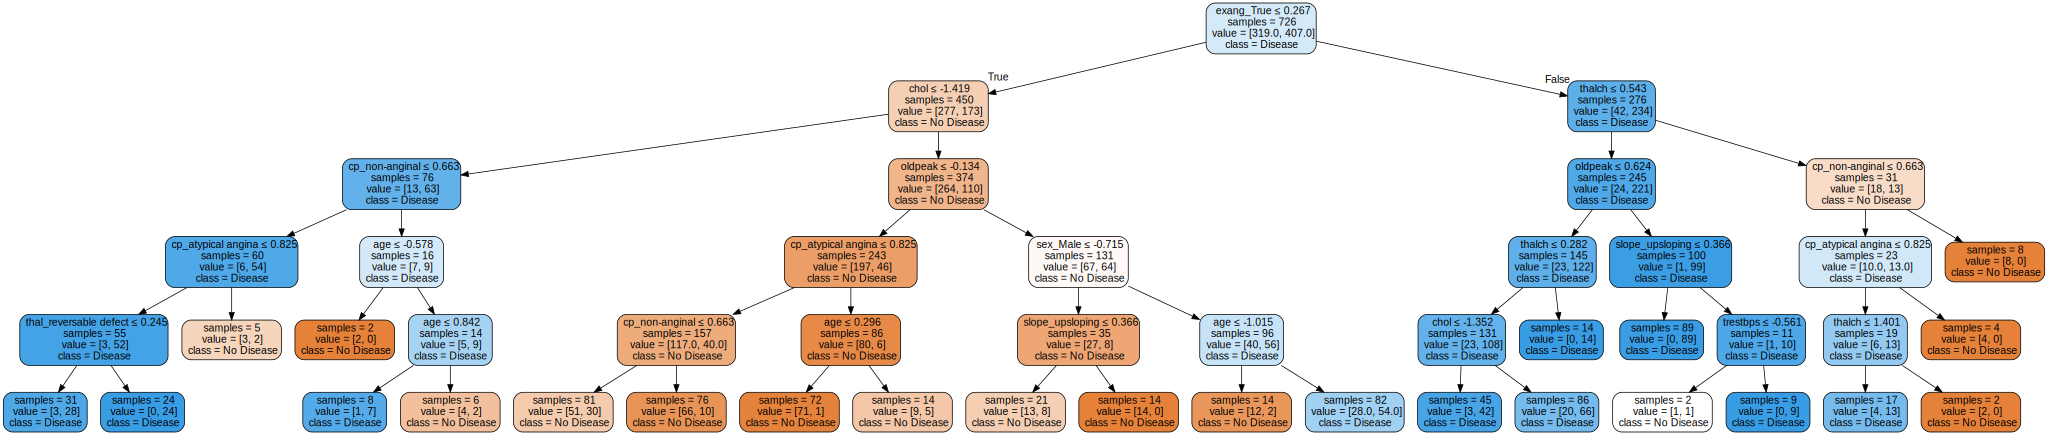


Decision Tree structure visualized above.


In [ ]:
# Render the graph (Requires graphviz to be installed)
graph = graphviz.Source(dot_data)
display(graph)

print("\nDecision Tree structure visualized above.")

## 6. Model Evaluation and Analysis

The Decision Tree model was optimized using `GridSearchCV` with 5-fold cross-validation, targeting the **F1-Score** to balance Precision and Recall for the heart disease prediction task.

### Optimal Hyperparameters Found:

| Parameter | Best Value | Rationale |
| :--- | :--- | :--- |
| **`criterion`** | `gini` | The Gini impurity often works slightly faster than Entropy and yielded the best performance in this case. |
| **`max_depth`** | `5` | A moderate depth prevents the model from overfitting while still capturing complex, non-linear relationships in the data. |
| **`min_samples_split`** | `5` | Requiring 5 samples to split a node ensures that decision rules are not based on very small, potentially noisy subsets of the data. |

### Final Performance on Test Set:

| Metric | Result | Interpretation |
| :--- | :--- | :--- |
| **Accuracy** | 0.7418 | The model correctly predicted the outcome (disease or no disease) 74.18% of the time. |
| **F1 Score (Disease)** | 0.7707 | A balanced metric showing good performance in identifying heart disease cases while keeping false positives low. |
| **ROC AUC Score** | 0.8025 | The model has a strong capacity to discriminate between the positive (disease) and negative (no disease) classes. An AUC over 0.8 is generally considered good performance. |

The visualization of the final tree (shown above) illustrates the rules (e.g., specific thresholds for `thalch`, `cp`, and `oldpeak`) that the model found most predictive of heart disease.

## Interview Questions

### 1. What are some common hyperparameters of decision tree models, and how do they affect the model's performance?

The hyperparameters of a Decision Tree model primarily function as **regularization constraints**, controlling the tree's complexity to prevent **overfitting** and improve its ability to **generalize** to unseen data.

| Hyperparameter | Description | Effect on Model Performance |
| :--- | :--- | :--- |
| **`criterion`** | The function used to measure the quality of a split (e.g., **Gini Impurity** or **Entropy**). | Determines which feature is selected for splitting. Gini is generally faster, while Entropy may sometimes produce better trees by maximizing information gain. |
| **`max_depth`** | The maximum number of levels (depth) the tree is allowed to grow. | **Primary Overfitting Control.** Limiting depth prevents the tree from becoming too specific to the training data noise. A smaller value increases **bias** but decreases **variance**. |
| **`min_samples_split`** | The minimum number of samples a node must contain before it is considered for splitting. | **Secondary Overfitting Control.** Increasing this value constrains the creation of splits based on very small groups, making the tree more robust and generalized. |
| **`min_samples_leaf`** | The minimum number of samples required to be present at a leaf node (the end of a branch). | Ensures that the final predictions are based on a sufficient number of observations, smoothing the decision boundary and reducing the impact of outliers. |

### 2. What is the difference between Label Encoding and One-Hot Encoding?

* **Label Encoding (LE):**
    * **Mechanism:** Assigns a unique **integer** to each category (e.g., 'Red' $\rightarrow 1$, 'Green' $\rightarrow 2$).
    * **Cons:** Introduces a false sense of **ordinality** (rank/order). A model might incorrectly assume that category '2' is "greater than" category '1', which is wrong for non-ordered data.
    * **Use Case:** Ideal for **Ordinal Features** (e.g., 'Low', 'Medium', 'High') or for the **Target Variable**.

* **One-Hot Encoding (OHE):**
    * **Mechanism:** Replaces a single categorical column with **multiple binary (0 or 1) columns**, one for each category.
    * **Pros:** Avoids the false ordinality problem; correctly represents nominal (non-ordered) data.
    * **Cons:** **Curse of Dimensionality** (adds many new features).
    * **Use Case:** Ideal for **Nominal Features** (e.g., 'Gender', 'Chest Pain Type').